# Otimização de hiperparâmetros e avaliação final

## Setup

In [1]:
%pip install pandas plotly matplotlib seaborn scikit-learn xgboost optuna hyperopt setuptools nbformat

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Módulo para leitura e manipulação dos dados
import pandas as pd

# Módulo para manipulação de arrays e matrizes
import numpy as np

# Módulos para visualização de dados e plotagem de gráficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos específicos da sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score,precision_score,recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Módulo para balanceamento de classes
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Otimizador
import optuna
from optuna.visualization import plot_optimization_history, plot_slice, plot_contour, plot_parallel_coordinate, plot_param_importances

c:\Users\Matheus\source\repos\ipp-student-dropout\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carregamento dos dados

Dataset pré-processado no notebook [t1-spot-checking.ipynb](./t1-spot-checking.ipynb)

---
Dataset obtido em https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data

Original: https://zenodo.org/records/5777340#.Y7FJotJBwUE

In [3]:
data = pd.read_csv("../data/clean-dataset.csv")

# 1. Otimização de hiperparâmetros

Cada algoritmo escolhido como resultado do T1 deve ser treinado para obter o melhor desempenho possível. Não havendo um referencial de desempenho para o problema, os grupos devem reportar o melhor modelo dentre todos os que foram treinados e avaliados. Isso envolve o melhor ajuste de hiperparâmetros que for possível encontrar. Automatizar essa etapa de otimização de hiperparâmetros pode economizar bastante esforço. O scikit-learn oferece o GridSearch que é uma busca exaustiva trivial. Assim, bibliotecas que implementam algoritmos mais “inteligentes”, como Hyperopt e Optuna, podem ser um diferencial na obtenção de um bom desempenho.

Os grupos devem garantir que a metodologia de pré-processamento, treino e validação esteja correta. Um aspecto particularmente crítico é a prevenção de data leakage (ie, vazamento de dados), que pode comprometer os resultados e a validade do modelo. Por exemplo, o cálculo das estatísticas de pré-processamento (e.g. fit do scikit-learn para normalização, balanceamento de dados e imputação) só pode ser feito nos dados de treino. Esse cálculo é, então, aplicado (e.g. transform do scikit-learn) nos dados de treino, validação e teste. Além disso, a otimização de hiperparâmetros deve ser avaliada no conjunto de validação e não no de teste.

A divisão dos dados em treino, validação e teste pode ser feita via holdout de 3-vias ou holdout+validação cruzada (CV), onde o holdout separa o de teste e o restante é dividido conforme a validação cruzada, ou validação cruzada (CV) aninhada. Os grupos devem avaliar qual a melhor estratégia, balanceando a confiabilidade do método (e.g. validação cruzada aninhada garante mais variabilidade nos dados) vs o tempo de execução (e.g. 5-folds externos e 3-folds internos de CV aninhada fazem com que cada possível modelo seja treinado e avaliado 15 vezes). Independente do método escolhido, a divisão dos dados deve ser estratificada (e.g. mesmo percentual de cada classe no treino, validação e teste).

In [4]:
# Algoritmos selecionados para otimização de hiperparâmetros

lr = LogisticRegression()
abc = AdaBoostClassifier()
svmachine = svm.SVC(probability=True)

algo_dict = {'Logistic Regression': lr, 'AdaBoost': abc, 'SVM': svmachine}

In [5]:
# Referências
# https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
def make_pipeline(model):
    steps = list()

    steps.append(('Feature Selection', SelectKBest(k=4, score_func=mutual_info_classif)))
    steps.append(('Normalização', StandardScaler()))
    steps.append(('Balanceamento da classe minoritária', SMOTE(sampling_strategy='minority')))
    steps.append(('Modelo', model))

    # Cria a pipeline
    pipe = Pipeline(steps=steps)

    return pipe

## Optuna

### Config

In [6]:
def define_optuna_space(model_name, trial):
    
    # Define o espaço de busca de hiperparâmetros para cada tipo de modelo
    if model_name == 'Logistic Regression':

        # Senão, com mais hiperparâmetros:
        solver_penalty_str = trial.suggest_categorical(
            'solver_penalty',
            ['liblinear_l1', 'liblinear_l2', 'lbfgs_l2']
        )

        # Quebra as strings de maneira a ter o solver e a penalidade certa
        solver, penalty = solver_penalty_str.split('_')

        return {
            'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True),
            'Modelo__solver': solver,
            'Modelo__penalty': penalty
        }

    elif model_name == 'AdaBoost':
        # Para AdaBoost, ajusta o número de estimadores e a taxa de aprendizado
        return {
            'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'Modelo__learning_rate': trial.suggest_float('learning_rate', 0.01, 2, log=True)
        }
    elif model_name == 'SVM':
        # Para SVM, ajusta o parâmetro C e o tipo de kernel
        return {
            'Modelo__C': trial.suggest_float('C', 1e-4, 1e2, log=True),
            'Modelo__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid'])
        }
    else:
        # Se nenhum hiperparâmetro estiver definido no modelo, retorna um dicionário vazio
        return {}

In [7]:
def objective_function(trial, model_name, model, X_train, y_train, inner_folds, metric):
    # Define o espaço de busca dos hiperparâmetros
    params = define_optuna_space(model_name, trial)

    # Cria o pipeline com seleção de atributos, normalização, balanceamento e o modelo
    pipeline = make_pipeline(model)

    # Ajusta o pipeline com os hiperparâmetros sugeridos pelo trial do optuna
    pipeline.set_params(**params)

    # Define o k-fold interno para validação cruzada
    inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)

    # Calcula a métrica de avaliação média (por ex. F1) através de validação cruzada
    score = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring=metric, n_jobs=-1).mean()
    return score


In [8]:
# Executa o estudo do Optuna para um único fold externo e retorna o melhor estudo
def run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=20):

    # Função objetivo que o Optuna irá otimizar
    def objective(trial):
        return objective_function(trial, model_name, model, X_train, y_train, inner_folds, metric)

    # Cria o estudo do Optuna com objetivo de maximizar a métrica
    study = optuna.create_study(direction="maximize")

    # Executa o estudo com número definido de tentativas (n_trials)
    study.optimize(objective, n_trials=n_trials)
    return study

In [9]:
# Avalia o modelo com os melhores parâmetros encontrados no conjunto de teste.
def evaluate_best_params(model, model_name, best_params, fold_number, X_train, y_train, X_test, y_test):
    pipeline = make_pipeline(model)
    pipeline.set_params(**best_params) # Ajusta o pipeline com os melhores parâmetros
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    return {
        'Algoritmo': model_name,
        'Número do Outer Fold': fold_number,
        'Parâmetros': best_params,
        'F1 Score': f1_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred),
        'Revocação': recall_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    }

In [10]:
# Separa atributos preditivos e atributo alvo
X = data.drop('Target', axis=1)
y = data['Target']

# Dividindo os dados entre treino e teste. Os dados de treino serão utilizados no Nested CV, 
# e os dados de teste serão utilizados posteriormente para avaliar os modelos
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

### Nested CV

In [11]:
def nested_cv_with_optuna(X, y, models, outer_folds=5, inner_folds=3, metric='f1', n_trials=20):

    # Define o k-fold externo para a nested cv
    outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
    results = []
    best_study_per_model = {}
    best_params_per_model = {}
    best_f1_per_model = {}

    # Loop pelos modelos que serão ajustados
    for model_name, model in models.items():
        best_f1 = -1
        best_study = None

        # Loop do k-fold externo
        for fold_number, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
            X_outer_train, X_outer_test = X.iloc[train_idx], X.iloc[test_idx]
            y_outer_train, y_outer_test = y.iloc[train_idx], y.iloc[test_idx]

            # Executa o estudo do Optuna para o fold atual
            study = run_optuna_study_for_fold(model_name, model, X_outer_train, y_outer_train, inner_folds, metric, n_trials=n_trials)

            # Obtém os melhores parâmetros do estudo
            best_params = {f'Modelo__{key}': value for key, value in study.best_params.items()}

            # Retira os pares de strings solver_penalty, caso presentes
            if 'Modelo__solver_penalty' in best_params:
                del best_params['Modelo__solver_penalty']

            # Avalia no conjunto de teste com os melhores parâmetros
            metrics = evaluate_best_params(model, model_name, best_params, fold_number, X_outer_train, y_outer_train, X_outer_test, y_outer_test)
            metrics['Algoritmo'] = model_name
            results.append(metrics)

            # Verifica se a pontuação (F1) melhorou em relação ao melhor caso anterior
            if metrics['F1 Score'] > best_f1:
                best_f1 = metrics['F1 Score']
                best_study = study
                best_params_per_model[model_name] = best_params

        best_study_per_model[model_name] = best_study
        best_f1_per_model[model_name] = best_f1

    # Retorna os resultados consolidados, o melhor estudo, os melhores parâmetros e a melhor pontuação F1 por modelo
    return pd.DataFrame(results), best_study_per_model, best_params_per_model, best_f1_per_model

Roda o Nested CV para otimização de hiperparâmetros entre Regressão Logística, AdaBoost e SVM.

In [12]:
optuna_algo_dict = {
    'Logistic Regression': algo_dict['Logistic Regression'],
    'AdaBoost': algo_dict['AdaBoost'],
    'SVM': algo_dict['SVM']
}

output = nested_cv_with_optuna(X_train, y_train, 
                                    optuna_algo_dict, 
                                    outer_folds=10,
                                    n_trials=50, 
                                    inner_folds=5, 
                                    metric='f1')

results_df, best_study_per_model, best_params_per_model, best_f1_per_model = output

[I 2024-12-14 10:00:43,145] A new study created in memory with name: no-name-6643e6e8-4c67-4802-977b-94d7d7b39164
[I 2024-12-14 10:00:44,308] Trial 0 finished with value: 0.7214978677400469 and parameters: {'solver_penalty': 'liblinear_l1', 'C': 0.0077869507909115124}. Best is trial 0 with value: 0.7214978677400469.
[I 2024-12-14 10:00:45,055] Trial 1 finished with value: 0.7209782553484321 and parameters: {'solver_penalty': 'liblinear_l2', 'C': 0.020439397600395537}. Best is trial 0 with value: 0.7214978677400469.
[I 2024-12-14 10:00:45,807] Trial 2 finished with value: 0.7234938125963313 and parameters: {'solver_penalty': 'liblinear_l1', 'C': 0.03498245331275267}. Best is trial 2 with value: 0.7234938125963313.
[I 2024-12-14 10:00:46,574] Trial 3 finished with value: 0.7246896096715083 and parameters: {'solver_penalty': 'liblinear_l1', 'C': 2.093530355206743}. Best is trial 3 with value: 0.7246896096715083.
[I 2024-12-14 10:00:47,285] Trial 4 finished with value: 0.7275394888342255 a

### Visualizações da otimização de hiperparâmetros

In [13]:
for model_name in best_params_per_model:
    print(f"Melhores parâmetros para {model_name}: {best_params_per_model[model_name]}")

Melhores parâmetros para Logistic Regression: {'Modelo__C': 0.0661402819042377}
Melhores parâmetros para AdaBoost: {'Modelo__n_estimators': 258, 'Modelo__learning_rate': 0.5686136448966946}
Melhores parâmetros para SVM: {'Modelo__C': 18.72430564502587, 'Modelo__kernel': 'rbf'}


In [14]:
# Exibe os melhores resultados e parâmetros para cada modelo
for model_name in best_study_per_model:
    print(f"Best F1 for {model_name}: {best_f1_per_model[model_name]}")
    print(f"Best Parameters for {model_name}: {best_params_per_model[model_name]}")

    print(f"Plots for model: {model_name}")

    study = best_study_per_model[model_name]
    fig_opt_history = plot_optimization_history(study)
    fig_opt_history.show()

    fig_slice = plot_slice(study)
    fig_slice.show()

    fig_parallel = plot_parallel_coordinate(study)
    fig_parallel.show()

    fig_contour = plot_contour(study)
    fig_contour.show()

    fig_param_importances = plot_param_importances(study)
    fig_param_importances.show()

Best F1 for Logistic Regression: 0.7668393782383419
Best Parameters for Logistic Regression: {'Modelo__C': 0.0661402819042377}
Plots for model: Logistic Regression


Best F1 for AdaBoost: 0.7867298578199052
Best Parameters for AdaBoost: {'Modelo__n_estimators': 258, 'Modelo__learning_rate': 0.5686136448966946}
Plots for model: AdaBoost


Best F1 for SVM: 0.7731958762886598
Best Parameters for SVM: {'Modelo__C': 18.72430564502587, 'Modelo__kernel': 'rbf'}
Plots for model: SVM


### Métricas da otimização

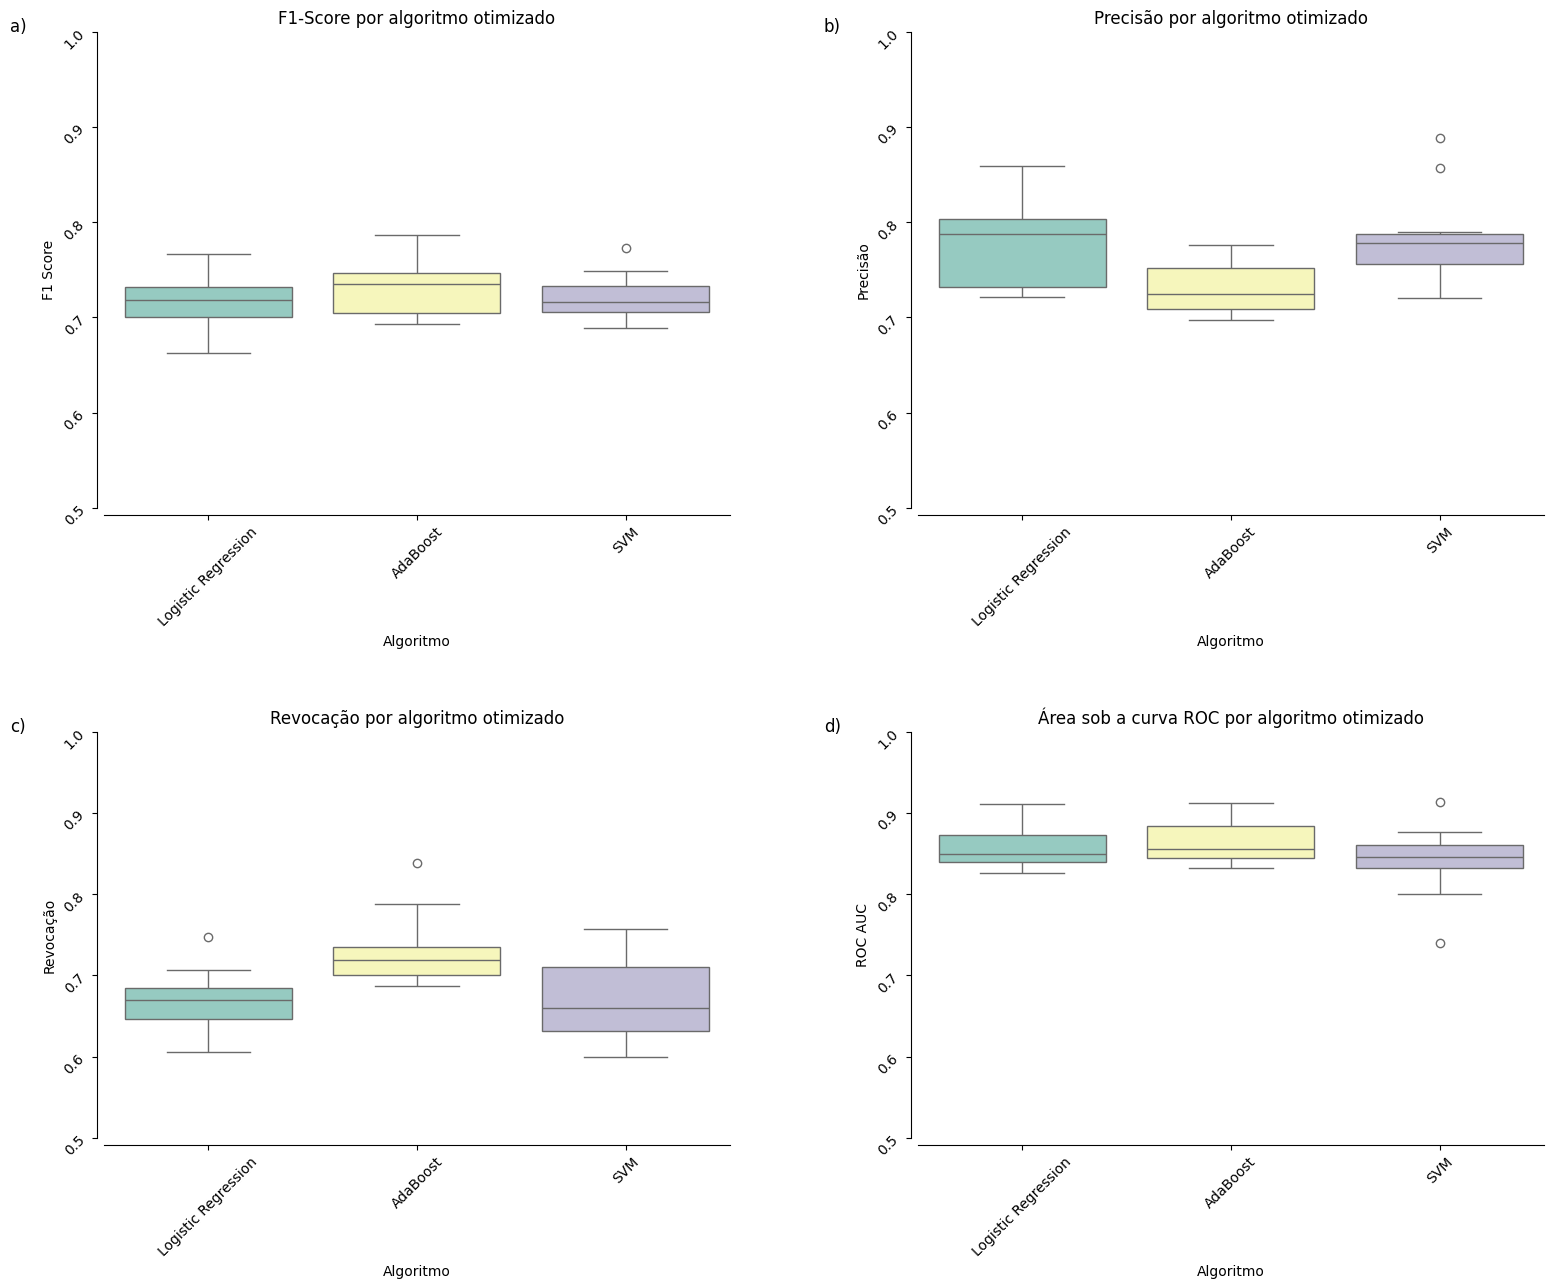

In [15]:
def letter_annotation(ax, xoffset, yoffset, letter):
 ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
         size=12)

fig = plt.figure(figsize=(12, 14))

# Cria 2 subfiguras para a primeira e segunda linha
(row1fig, row2fig) = fig.subfigures(2, 1, height_ratios=[1,1])

# Primeira linha
row1_axs = row1fig.subplots(1, 2)
row1fig.subplots_adjust(wspace=0.3, hspace=0.01, left=0, right=1.2, bottom=.2)

# Segunda linha
row2_axs = row2fig.subplots(1, 2)
row2fig.subplots_adjust(wspace=0.3, hspace=0.01, left=0, right=1.2, bottom=.3)

# F1-Score
# ============================================================
ax = row1_axs[0]
sns.boxplot(data=results_df, x='Algoritmo', y='F1 Score', hue='Algoritmo', palette='Set3', ax=ax)
ax.tick_params(labelrotation=45)
ax.set_ylim(0.5, 1.0)
ax.set_title('F1-Score por algoritmo otimizado')
letter_annotation(ax, -.15, 1, 'a)')
sns.despine(offset=5, trim=False, ax=ax)

# Precisão
# ============================================================
ax = row1_axs[1]
sns.boxplot(data=results_df, x='Algoritmo', y='Precisão', hue='Algoritmo', palette='Set3', ax=ax)
ax.tick_params(labelrotation=45)
ax.set_ylim(0.5, 1.0)
ax.set_title('Precisão por algoritmo otimizado')
letter_annotation(ax, -.15, 1, 'b)')
sns.despine(offset=5, trim=False, ax=ax)

# Recall
# ============================================================
ax = row2_axs[0]
sns.boxplot(data=results_df, x='Algoritmo', y='Revocação', hue='Algoritmo', palette='Set3', ax=ax)
ax.tick_params(labelrotation=45)
ax.set_ylim(0.5, 1.0)
ax.set_title('Revocação por algoritmo otimizado')
letter_annotation(ax, -.15, 1, 'c)')
sns.despine(offset=5, trim=False, ax=ax)

# ROC AUC
# ============================================================
ax = row2_axs[1]
sns.boxplot(data=results_df, x='Algoritmo', y='ROC AUC', hue='Algoritmo', palette='Set3', ax=ax)
ax.tick_params(labelrotation=45)
ax.set_ylim(0.5, 1.0)
ax.set_title('Área sob a curva ROC por algoritmo otimizado')
letter_annotation(ax, -.15, 1, 'd)')
sns.despine(offset=5, trim=False, ax=ax)

# ============================================================
plt.show()

### Seleção de modelo

Mostra os resultados do Outer Fold, sumarizando as avaliações no fold de teste e melhores parâmetros estudados.

In [16]:
display(results_df)

,Algoritmo,Número do Outer Fold,Parâmetros,F1 Score,Precisão,Revocação,ROC AUC
0,Logistic Regression,0,{'Modelo__C': 147.31087292499816},0.662983,0.731707,0.606061,0.845469
1,Logistic Regression,1,{'Modelo__C': 0.0661402819042377},0.766839,0.787234,0.747475,0.910575
2,Logistic Regression,2,{'Modelo__C': 1.46018040284133},0.707865,0.807692,0.630000,0.826190
3,Logistic Regression,3,{'Modelo__C': 0.5237494619258751},0.724324,0.788235,0.670000,0.873738
4,Logistic Regression,4,{'Modelo__C': 0.13029472047995186},0.723164,0.831169,0.640000,0.838381
5,Logistic Regression,5,{'Modelo__C': 641.2088623687298},0.697917,0.728261,0.670000,0.851310
6,Logistic Regression,6,{'Modelo__C': 27.97451054946336},0.757062,0.858974,0.676768,0.902237
7,Logistic Regression,7,{'Modelo__C': 34.3331047911531},0.735135,0.790698,0.686869,0.868326
8,Logistic Regression,8,{'Modelo__C': 10.719768352245639},0.698413,0.733333,0.666667,0.847066
9,Logistic Regression,9,{'Modelo__C': 5.8296505655212},0.714286,0.721649,0.707071,0.830664


Selecionaremos para o treinamento final os algoritmos com melhor F1-Score, nossa métrica principal.

In [17]:
best_f1_score_and_params = results_df.loc[results_df.groupby('Algoritmo')['F1 Score'].idxmax(), ['Algoritmo', 'F1 Score', 'Parâmetros']].set_index('Algoritmo').to_dict('index')

print("Melhores F1 Score e respectivos parâmetros de cada algoritmo:")
print(best_f1_score_and_params)

Melhores F1 Score e respectivos parâmetros de cada algoritmo:
{'AdaBoost': {'F1 Score': 0.7867298578199052, 'Parâmetros': {'Modelo__n_estimators': 258, 'Modelo__learning_rate': 0.5686136448966946}}, 'Logistic Regression': {'F1 Score': 0.7668393782383419, 'Parâmetros': {'Modelo__C': 0.0661402819042377}}, 'SVM': {'F1 Score': 0.7731958762886598, 'Parâmetros': {'Modelo__C': 18.72430564502587, 'Modelo__kernel': 'rbf'}}}


# 2. Avaliação de desempenho final

Utilizem as métricas definidas na primeira parte do trabalho para comparar os modelos, garantindo que a métrica seja a correta para o problema, considerando eventuais desbalanceamentos nos dados.
Após a otimização de hiperparâmetros de todos os modelos candidatos (isto é, aqueles treinados com 2-3 estratégias mais promissoras escolhidas com base em T1), o desempenho dos modelos nos dados de teste deve ser comparado para identificar qual modelo oferece o melhor desempenho global e quais são os pontos fortes e fracos de cada modelo. Com base nesta análise, os grupos devem tentar definir o modelo mais indicado para atacar o problema abordado.

Criem gráficos e visualizações que ajudem a ilustrar as comparações entre os modelos. Conforme apropriado, obtenham curvas ROC ou PR, gráficos de barras comparando as métricas de cada modelo, e/ou matrizes de confusão.

Identifiquem o melhor modelo, ou se não há um modelo claramente melhor, quais são os “vencedores” e as situações e características de vantagem e desvantagem entre eles. Verifiquem os casos (instâncias/amostras) onde o melhor modelo (ou os melhores, em caso de “empate”) vai(vão) bem ou mal. A análise não deve ser pra cada amostra individual, mas de maneira agregada. Por exemplo, se o problema for de classificação, analise qual é a classe mais difícil para o modelo, e se há amostras “confusas” no sentido que seus atributos parecem realmente pertencer a outra classe. Se o problema é de regressão, veja se há algum padrão onde os erros são maiores.

---

Após otimizar e encontrar a melhor pipeline de modelagem, realizaremos seu treinamento em todo o conjunto treino, para finalmente validar no conjunto de teste, reservado anteriormente para este momento.

## Logistic Regression

In [18]:
best_params = best_f1_score_and_params['Logistic Regression']['Parâmetros']
print(best_params)

# Evaluate the best model on the test set
best_pipeline = make_pipeline(model=algo_dict['Logistic Regression'])
best_pipeline.set_params(Modelo__C = best_params['Modelo__C'])


best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

{'Modelo__C': 0.0661402819042377}


In [19]:
final_results_lr = {
    'F1 Score': f1_score(y_test, y_pred),
    'Precisão': precision_score(y_test, y_pred),
    'Revocação': recall_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba)
}

print("Avaliação final no conjunto de testes", final_results_lr)

Avaliação final no conjunto de testes {'F1 Score': np.float64(0.7574257425742574), 'Precisão': np.float64(0.8031496062992126), 'Revocação': np.float64(0.7166276346604216), 'ROC AUC': np.float64(0.876638499507443)}


C:\Users\Matheus\AppData\Local\Temp\ipykernel_18184\765875281.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




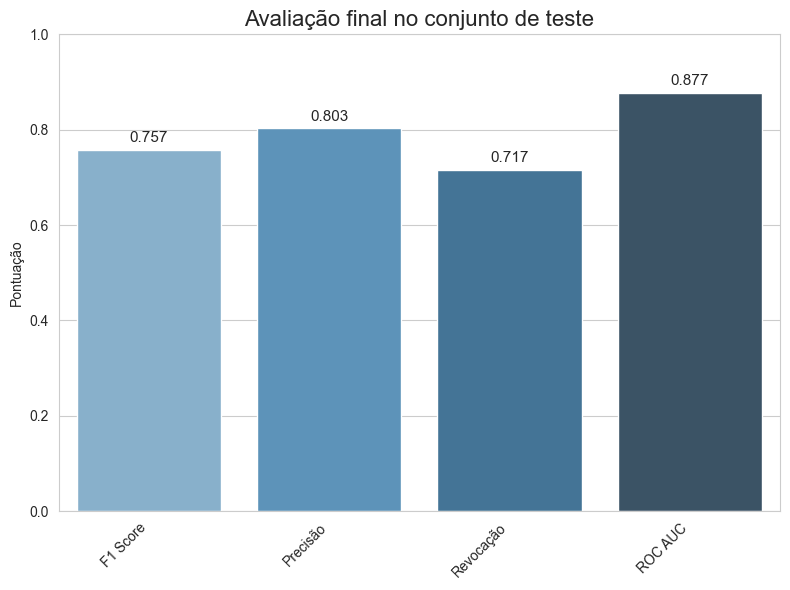

In [20]:
# Convert final_results into a DataFrame for easy plotting
final_results_df = pd.DataFrame(list(final_results_lr.items()), columns=['Metric', 'Value'])

# Set a style for seaborn
sns.set_style("whitegrid")

# Create a figure and axes
plt.figure(figsize=(8, 6))

# Plot the bar chart
sns.barplot(x='Metric', y='Value', data=final_results_df, palette='Blues_d')

# Add labels and title
plt.title("Avaliação final no conjunto de teste", fontsize=16)
plt.ylim(0, 1.0)
for index, row in final_results_df.iterrows():
    plt.text(index, row['Value'] + 0.01, f"{row['Value']:.3f}", 
             ha='center', va='bottom', fontsize=11)

plt.xlabel("")
plt.ylabel("Pontuação")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

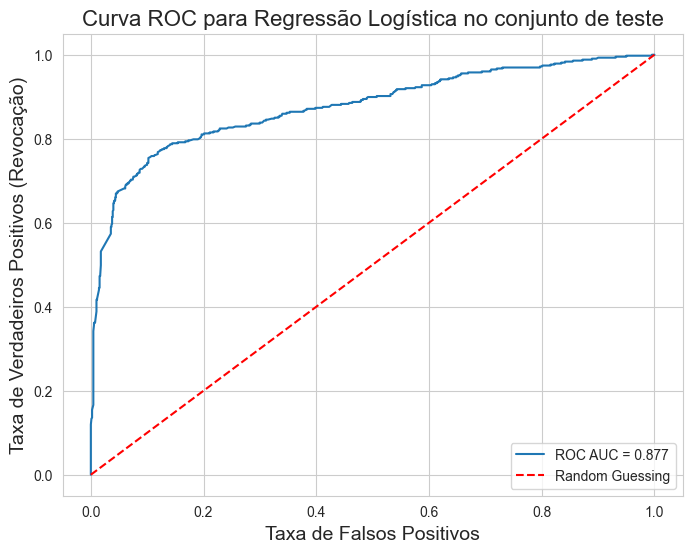

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {final_results_lr['ROC AUC']:.3f}")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guessing")

plt.title("Curva ROC para Regressão Logística no conjunto de teste", fontsize=16)
plt.xlabel("Taxa de Falsos Positivos", fontsize=14)
plt.ylabel("Taxa de Verdadeiros Positivos (Revocação)", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

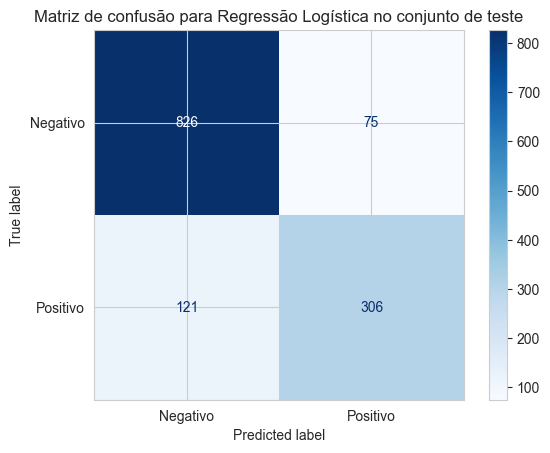

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using the built-in confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negativo', 'Positivo'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de confusão para Regressão Logística no conjunto de teste")
plt.show()

## AdaBoost

In [23]:
best_params = best_f1_score_and_params['AdaBoost']['Parâmetros']
print(best_params)

best_pipeline = make_pipeline(model=algo_dict['AdaBoost'])
best_pipeline.set_params(Modelo__n_estimators=best_params['Modelo__n_estimators'],
                         Modelo__learning_rate=best_params['Modelo__learning_rate'])

best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

{'Modelo__n_estimators': 258, 'Modelo__learning_rate': 0.5686136448966946}


c:\Users\Matheus\source\repos\ipp-student-dropout\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



In [24]:
final_results_abc = {
    'F1 Score': f1_score(y_test, y_pred),
    'Precisão': precision_score(y_test, y_pred),
    'Revocação': recall_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba)
}

print("Avaliação final no conjunto de testes", final_results_abc)

Avaliação final no conjunto de testes {'F1 Score': np.float64(0.7558139534883721), 'Precisão': np.float64(0.7505773672055427), 'Revocação': np.float64(0.7611241217798594), 'ROC AUC': np.float64(0.8894761740143011)}


C:\Users\Matheus\AppData\Local\Temp\ipykernel_18184\723230486.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




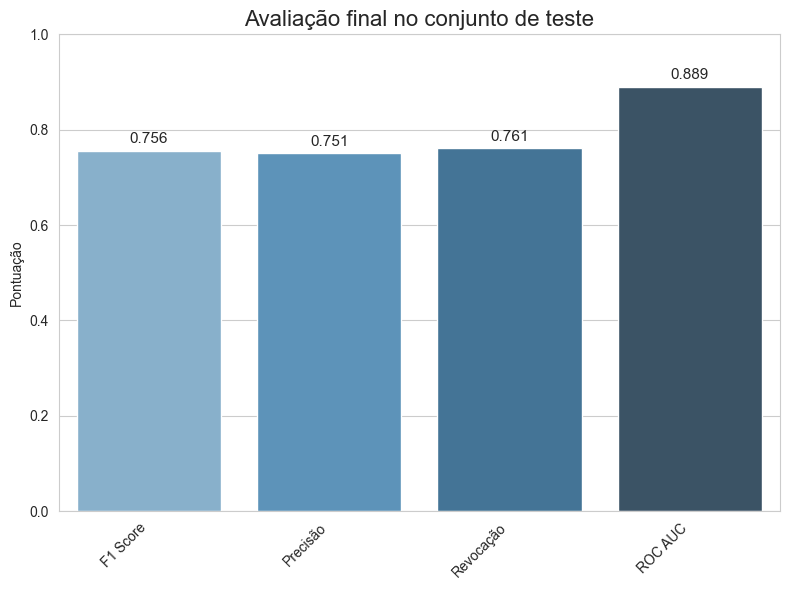

In [25]:
# Convert final_results into a DataFrame for easy plotting
final_results_df = pd.DataFrame(list(final_results_abc.items()), columns=['Metric', 'Value'])

# Set a style for seaborn
sns.set_style("whitegrid")

# Create a figure and axes
plt.figure(figsize=(8, 6))

# Plot the bar chart
sns.barplot(x='Metric', y='Value', data=final_results_df, palette='Blues_d')

# Add labels and title
plt.title("Avaliação final no conjunto de teste", fontsize=16)
plt.ylim(0, 1.0)
for index, row in final_results_df.iterrows():
    plt.text(index, row['Value'] + 0.01, f"{row['Value']:.3f}", 
             ha='center', va='bottom', fontsize=11)

plt.xlabel("")
plt.ylabel("Pontuação")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

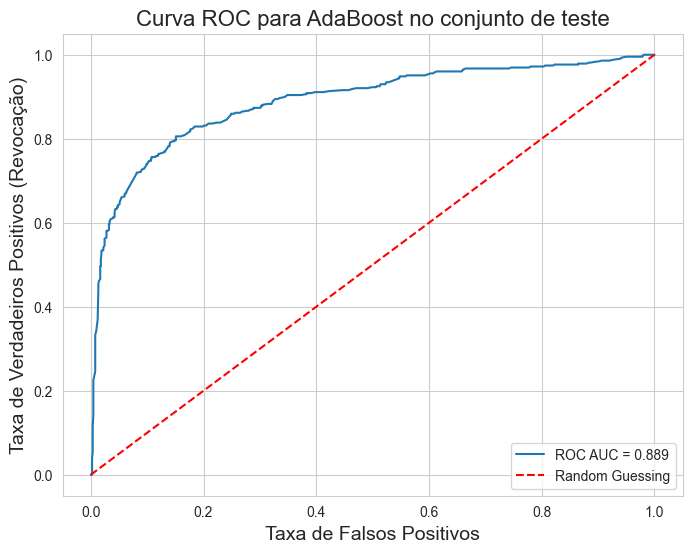

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {final_results_abc['ROC AUC']:.3f}")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guessing")

plt.title("Curva ROC para AdaBoost no conjunto de teste", fontsize=16)
plt.xlabel("Taxa de Falsos Positivos", fontsize=14)
plt.ylabel("Taxa de Verdadeiros Positivos (Revocação)", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

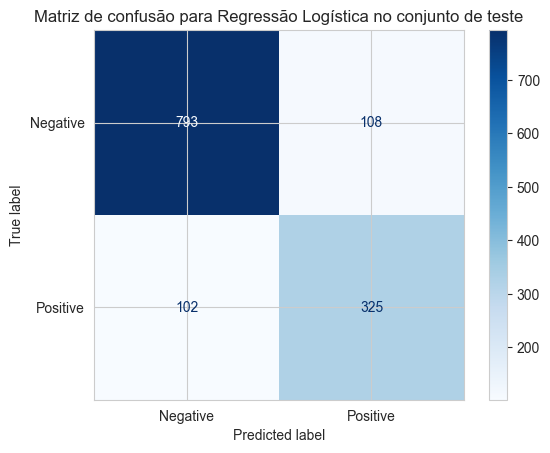

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using the built-in confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de confusão para Regressão Logística no conjunto de teste")
plt.show()

## SVM

In [28]:
best_params = best_f1_score_and_params['SVM']['Parâmetros']
print(best_params)

# Evaluate the best model on the test set
best_pipeline = make_pipeline(model=algo_dict['SVM'])
best_pipeline.set_params(Modelo__C = best_params['Modelo__C'], 
                         Modelo__kernel = best_params['Modelo__kernel'])

best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

{'Modelo__C': 18.72430564502587, 'Modelo__kernel': 'rbf'}


In [29]:
final_results_svm = {
    'F1 Score': f1_score(y_test, y_pred),
    'Precisão': precision_score(y_test, y_pred),
    'Revocação': recall_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba)
}

print("Avaliação final no conjunto de testes", final_results_svm)

Avaliação final no conjunto de testes {'F1 Score': np.float64(0.7471698113207547), 'Precisão': np.float64(0.8070652173913043), 'Revocação': np.float64(0.6955503512880562), 'ROC AUC': np.float64(0.868301418928227)}


C:\Users\Matheus\AppData\Local\Temp\ipykernel_18184\1372933712.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




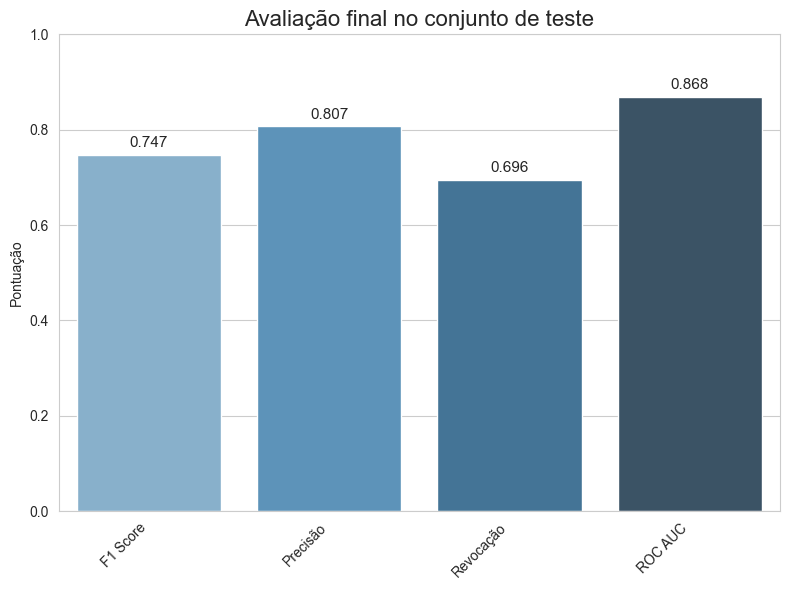

In [30]:
# Convert final_results into a DataFrame for easy plotting
final_results_df = pd.DataFrame(list(final_results_svm.items()), columns=['Metric', 'Value'])

# Set a style for seaborn
sns.set_style("whitegrid")

# Create a figure and axes
plt.figure(figsize=(8, 6))

# Plot the bar chart
sns.barplot(x='Metric', y='Value', data=final_results_df, palette='Blues_d')

# Add labels and title
plt.title("Avaliação final no conjunto de teste", fontsize=16)
plt.ylim(0, 1.0)
for index, row in final_results_df.iterrows():
    plt.text(index, row['Value'] + 0.01, f"{row['Value']:.3f}", 
             ha='center', va='bottom', fontsize=11)

plt.xlabel("")
plt.ylabel("Pontuação")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

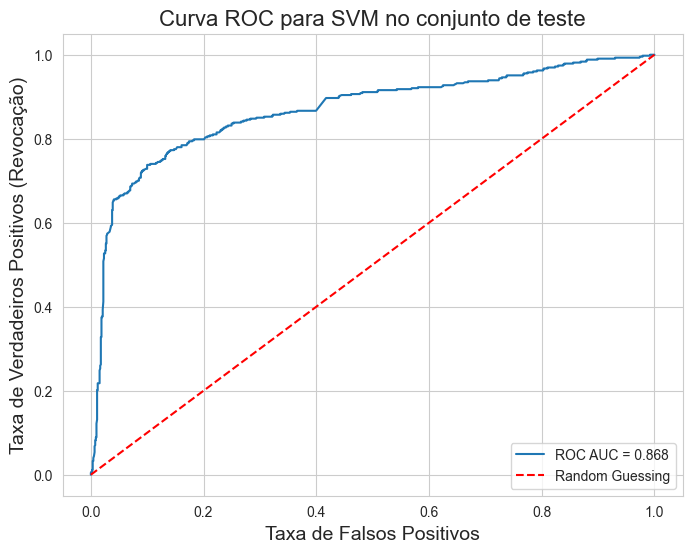

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {final_results_svm['ROC AUC']:.3f}")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guessing")

plt.title("Curva ROC para SVM no conjunto de teste", fontsize=16)
plt.xlabel("Taxa de Falsos Positivos", fontsize=14)
plt.ylabel("Taxa de Verdadeiros Positivos (Revocação)", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

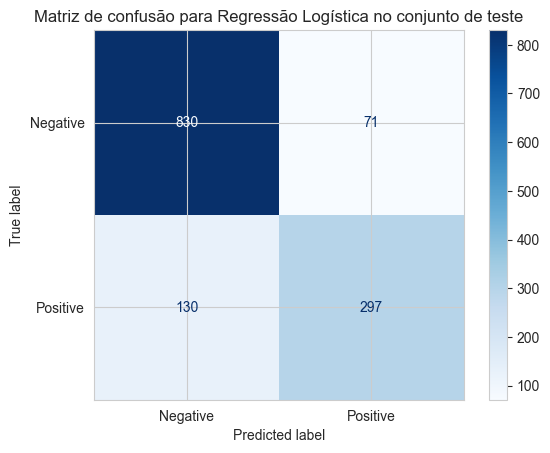

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using the built-in confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de confusão para Regressão Logística no conjunto de teste")
plt.show()

# 3. Comparação

In [33]:
def letter_annotation(ax, xoffset, yoffset, letter):
 ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
         size=12)

,Algoritmo,Precisão
0,Logistic Regression,0.803150
1,AdaBoost,0.750577
2,SVM,0.807065


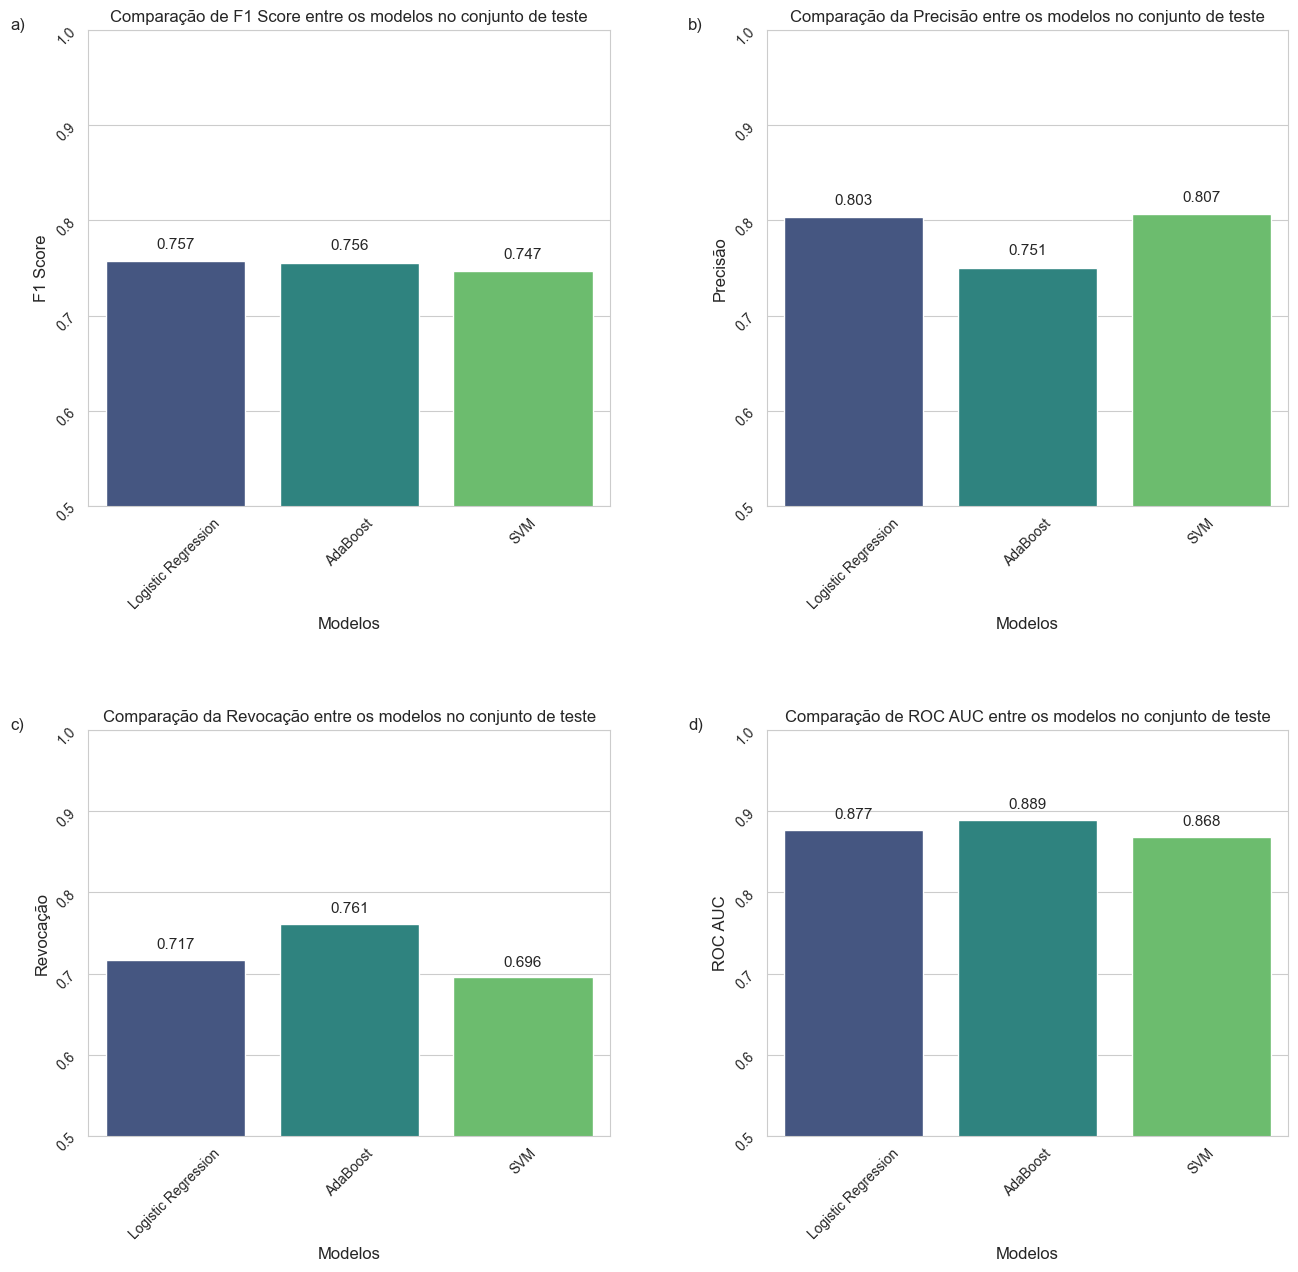

In [34]:
fig = plt.figure(figsize=(10, 14))

# Cria 2 subfiguras para a primeira e segunda linha
(row1fig, row2fig) = fig.subfigures(2, 1, height_ratios=[1,1])

# Primeira linha
row1_axs = row1fig.subplots(1, 2)
row1fig.subplots_adjust(wspace=0.3, hspace=0.01, left=0, right=1.2, bottom=.2)

# Segunda linha
row2_axs = row2fig.subplots(1, 2)
row2fig.subplots_adjust(wspace=0.3, hspace=0.01, left=0, right=1.2, bottom=.3)


# Dados dos F1 Scores dos modelos
final_results = {
    'Logistic Regression': final_results_lr['F1 Score'],
    'AdaBoost': final_results_abc['F1 Score'],
    'SVM': final_results_svm['F1 Score']
}

# Dados das precisões dos modelos
precision_results = {
    'Logistic Regression': final_results_lr['Precisão'],
    'AdaBoost': final_results_abc['Precisão'],
    'SVM': final_results_svm['Precisão']
}

# Convertendo os dados para um DataFrame
precision_results_df = pd.DataFrame(list(precision_results.items()), columns=['Algoritmo', 'Precisão'])
display(precision_results_df)

# Dados das revocações dos modelos
recall_results = {
    'Logistic Regression': final_results_lr['Revocação'],
    'AdaBoost': final_results_abc['Revocação'],
    'SVM': final_results_svm['Revocação']
}

# Convertendo os dados para um DataFrame
recall_results_df = pd.DataFrame(list(recall_results.items()), columns=['Algoritmo', 'Revocação'])

# Dados das ROC AUC dos modelos
roc_auc_results = {
    'Logistic Regression': final_results_lr['ROC AUC'],
    'AdaBoost': final_results_abc['ROC AUC'],
    'SVM': final_results_svm['ROC AUC']
}

# Convertendo os dados para um DataFrame
roc_auc_results_df = pd.DataFrame(list(roc_auc_results.items()), columns=['Algoritmo', 'ROC AUC'])

# Convertendo os dados para um DataFrame
final_df = pd.DataFrame(list(final_results.items()), columns=['Algoritmo', 'F1 Score'])

# == F1 Score ================================================
ax = row1_axs[0]
sns.barplot(x='Algoritmo', y='F1 Score', data=final_df, hue='Algoritmo', palette='viridis', ax=ax)
ax.set_title('Comparação de F1 Score entre os modelos no conjunto de teste', fontsize=12)
for index, row in final_df.iterrows():
    ax.text(index, row['F1 Score'] + 0.01, f"{row['F1 Score']:.3f}",
             ha='center', va='bottom', fontsize=11)
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.tick_params(labelrotation=45)
ax.set_ylim(0.5, 1)
letter_annotation(ax, -.15, 1, 'a)')

# == Precisão ================================================
ax = row1_axs[1]
sns.barplot(x='Algoritmo', y='Precisão', data=precision_results_df, hue='Algoritmo', palette='viridis', ax=ax)
ax.set_title('Comparação da Precisão entre os modelos no conjunto de teste', fontsize=12)
for index, row in precision_results_df.iterrows():
    ax.text(index, row['Precisão'] + 0.01, f"{row['Precisão']:.3f}",
             ha='center', va='bottom', fontsize=11)
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Precisão', fontsize=12)
ax.tick_params(labelrotation=45)
ax.set_ylim(0.5, 1)
letter_annotation(ax, -.15, 1, 'b)')

# == Revocaçao ================================================
ax = row2_axs[0]
sns.barplot(x='Algoritmo', y='Revocação', data=recall_results_df, hue='Algoritmo', palette='viridis', ax=ax)
ax.set_title('Comparação da Revocação entre os modelos no conjunto de teste', fontsize=12)
for index, row in recall_results_df.iterrows():
    ax.text(index, row['Revocação'] + 0.01, f"{row['Revocação']:.3f}",
             ha='center', va='bottom', fontsize=11)
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Revocação', fontsize=12)
ax.tick_params(labelrotation=45)
ax.set_ylim(0.5, 1)
letter_annotation(ax, -.15, 1, 'c)')

# == ROC AUC ================================================
ax = row2_axs[1]
sns.barplot(x='Algoritmo', y='ROC AUC', data=roc_auc_results_df, hue='Algoritmo', palette='viridis')
ax.set_title('Comparação de ROC AUC entre os modelos no conjunto de teste', fontsize=12)
for index, row in roc_auc_results_df.iterrows():
    ax.text(index, row['ROC AUC'] + 0.01, f"{row['ROC AUC']:.3f}",
             ha='center', va='bottom', fontsize=11)
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('ROC AUC', fontsize=12)
ax.tick_params(labelrotation=45)
ax.set_ylim(0.5, 1)
letter_annotation(ax, -.15, 1, 'd)')

# ============================================================
plt.show()

,Algoritmo,Precisão
0,Logistic Regression,0.803150
1,AdaBoost,0.750577
2,SVM,0.807065


C:\Users\Matheus\AppData\Local\Temp\ipykernel_18184\1504549477.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




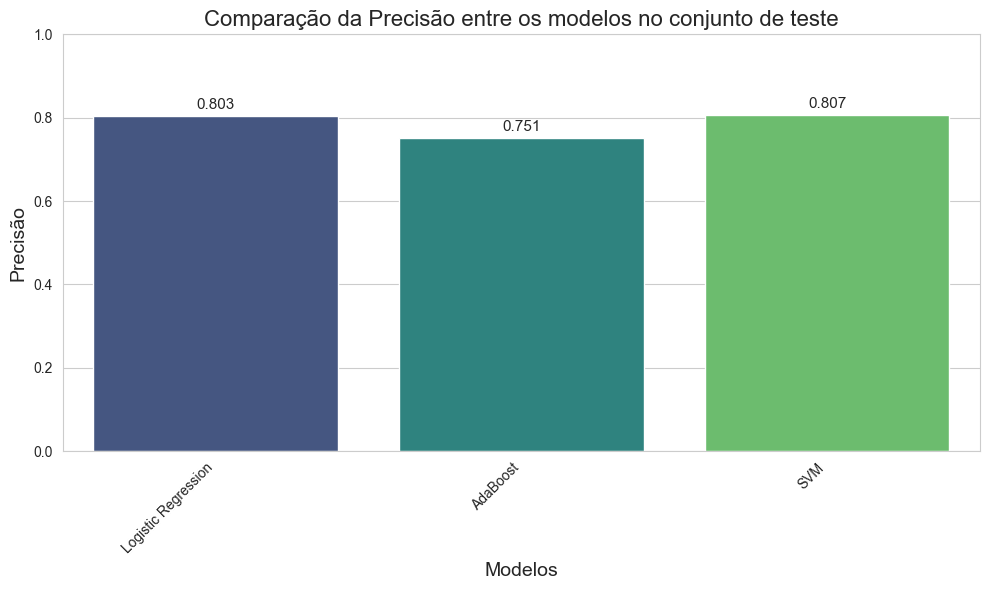

In [35]:
# Dados das precisões dos modelos
precision_results = {
    'Logistic Regression': final_results_lr['Precisão'],
    'AdaBoost': final_results_abc['Precisão'],
    'SVM': final_results_svm['Precisão']
}

# Convertendo os dados para um DataFrame
precision_results_df = pd.DataFrame(list(precision_results.items()), columns=['Algoritmo', 'Precisão'])
display(precision_results_df)

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Algoritmo', y='Precisão', data=precision_results_df, palette='viridis')

# Adicionando rótulos e título
plt.title('Comparação da Precisão entre os modelos no conjunto de teste', fontsize=16)
plt.ylim(0, 1.0)
for index, row in precision_results_df.iterrows():
    plt.text(index, row['Precisão'] + 0.01, f"{row['Precisão']:.3f}", 
             ha='center', va='bottom', fontsize=11)

plt.xlabel('Modelos', fontsize=14)
plt.ylabel('Precisão', fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18184\1530275296.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




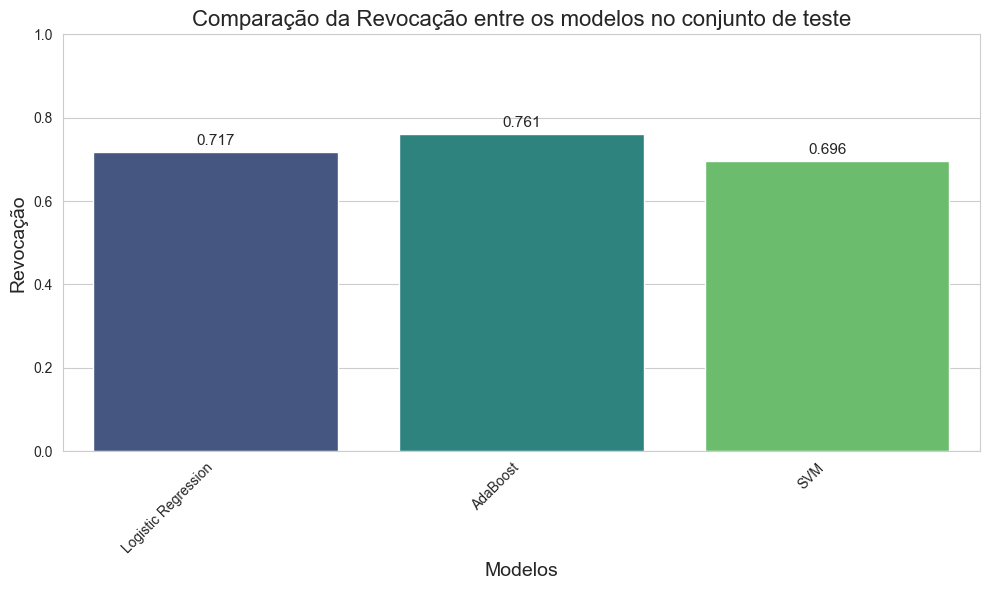

In [36]:
# Dados das revocações dos modelos
recall_results = {
    'Logistic Regression': final_results_lr['Revocação'],
    'AdaBoost': final_results_abc['Revocação'],
    'SVM': final_results_svm['Revocação']
}

# Convertendo os dados para um DataFrame
recall_results_df = pd.DataFrame(list(recall_results.items()), columns=['Algoritmo', 'Revocação'])

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Algoritmo', y='Revocação', data=recall_results_df, palette='viridis')

# Adicionando rótulos e título
plt.title('Comparação da Revocação entre os modelos no conjunto de teste', fontsize=16)
plt.ylim(0, 1.0)
for index, row in recall_results_df.iterrows():
    plt.text(index, row['Revocação'] + 0.01, f"{row['Revocação']:.3f}", 
             ha='center', va='bottom', fontsize=11)

plt.xlabel('Modelos', fontsize=14)
plt.ylabel('Revocação', fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18184\1600593402.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




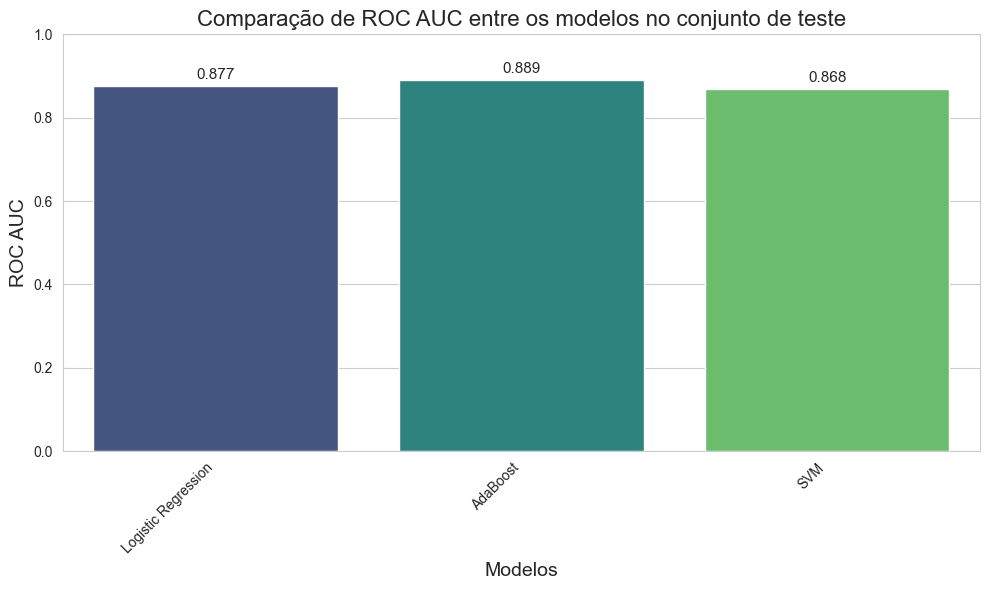

In [37]:
# Dados das ROC AUC dos modelos
roc_auc_results = {
    'Logistic Regression': final_results_lr['ROC AUC'],
    'AdaBoost': final_results_abc['ROC AUC'],
    'SVM': final_results_svm['ROC AUC']
}

# Convertendo os dados para um DataFrame
roc_auc_results_df = pd.DataFrame(list(roc_auc_results.items()), columns=['Algoritmo', 'ROC AUC'])

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Algoritmo', y='ROC AUC', data=roc_auc_results_df, palette='viridis')

# Adicionando rótulos e título
plt.title('Comparação de ROC AUC entre os modelos no conjunto de teste', fontsize=16)
plt.ylim(0, 1.0)
for index, row in roc_auc_results_df.iterrows():
    plt.text(index, row['ROC AUC'] + 0.01, f"{row['ROC AUC']:.3f}", 
             ha='center', va='bottom', fontsize=11)

plt.xlabel('Modelos', fontsize=14)
plt.ylabel('ROC AUC', fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

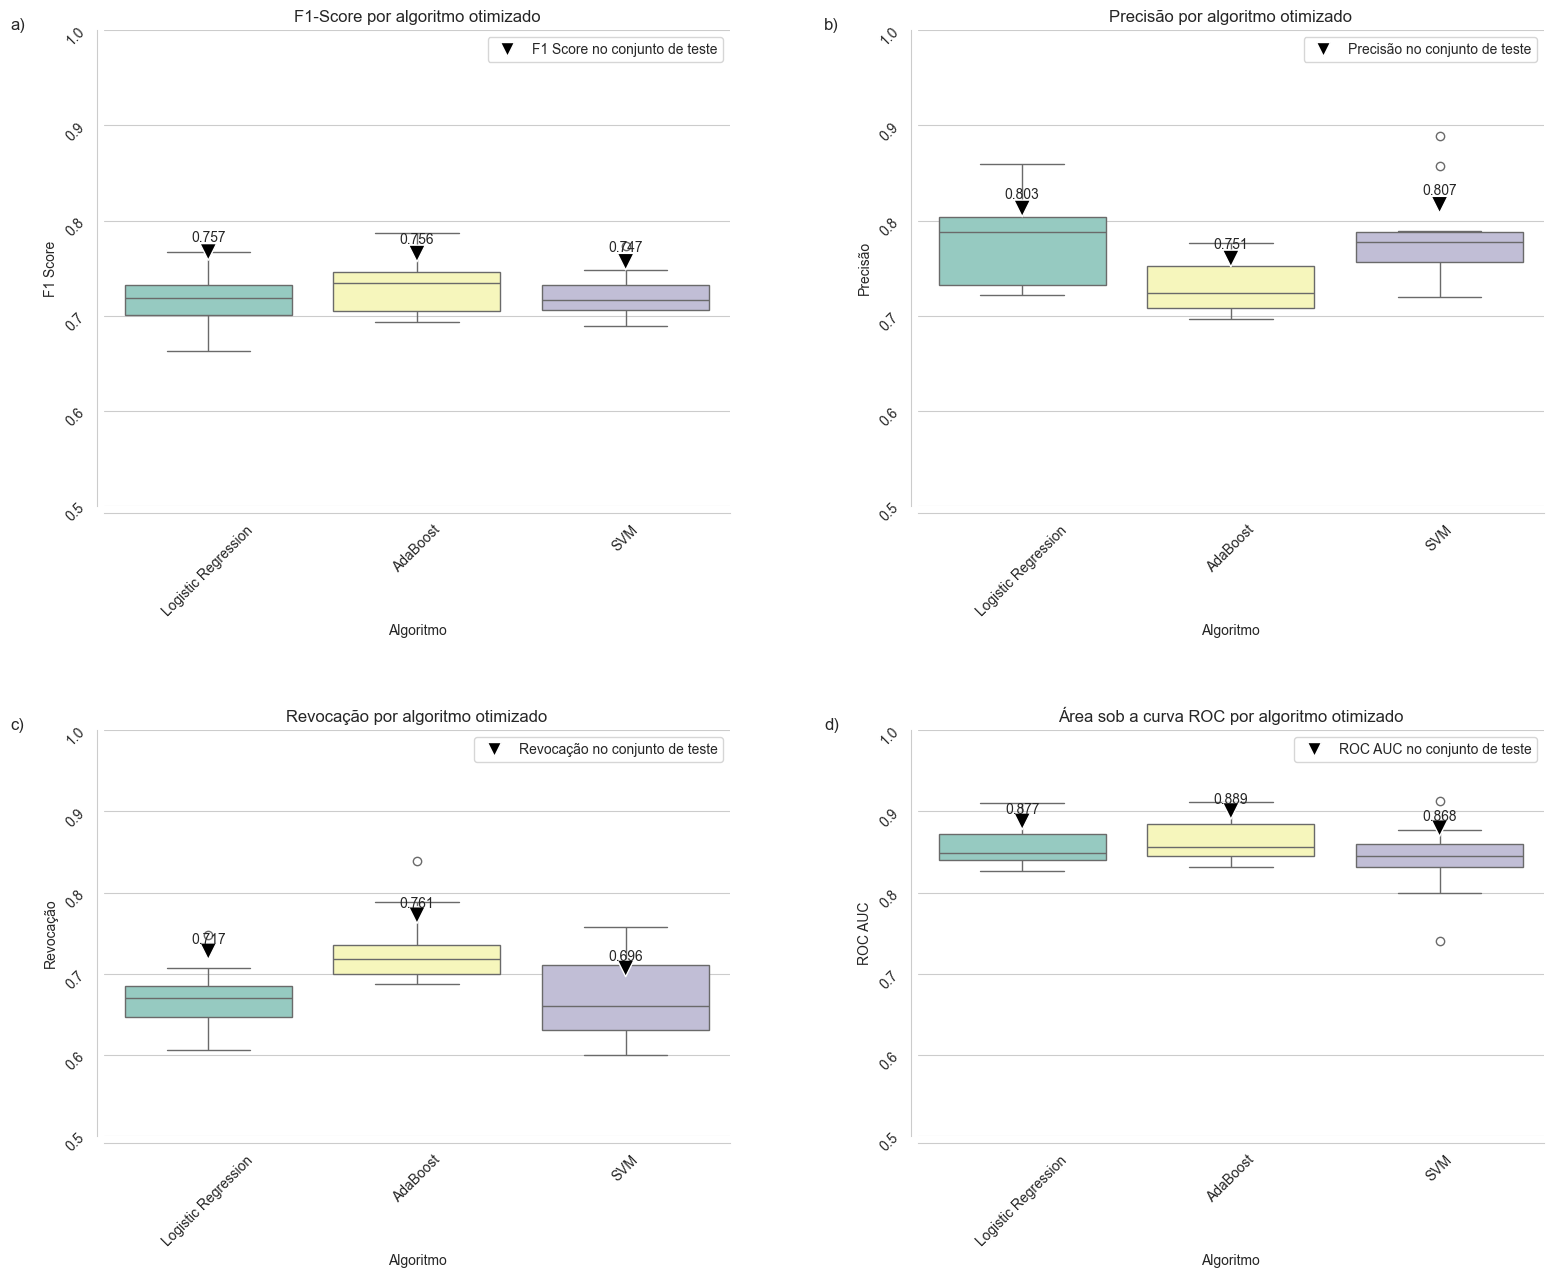

In [40]:
def letter_annotation(ax, xoffset, yoffset, letter):
 ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
                 size=12)

fig = plt.figure(figsize=(12, 14))

# Cria 2 subfiguras para a primeira e segunda linha
(row1fig, row2fig) = fig.subfigures(2, 1, height_ratios=[1,1])

# Primeira linha
row1_axs = row1fig.subplots(1, 2)
row1fig.subplots_adjust(wspace=0.3, hspace=0.01, left=0, right=1.2, bottom=.2)

# Segunda linha
row2_axs = row2fig.subplots(1, 2)
row2fig.subplots_adjust(wspace=0.3, hspace=0.01, left=0, right=1.2, bottom=.3)

# F1-Score
# ============================================================
ax = row1_axs[0]
sns.boxplot(data=results_df, x='Algoritmo', y='F1 Score', hue='Algoritmo', palette='Set3', ax=ax)
ax.tick_params(labelrotation=45)
ax.set_ylim(0.5, 1.0)
ax.set_title('F1-Score por algoritmo otimizado')
letter_annotation(ax, -.15, 1, 'a)')
sns.despine(offset=5, trim=False, ax=ax)

# Adiciona um ponto específico do df final_df
for index, row in final_df.iterrows():
        ax.annotate(f"{row['F1 Score']:.3f}", 
                                xy=(index, row['F1 Score']), 
                                xytext=(index, row['F1 Score'] + 0.02),
                                arrowprops=dict(facecolor='black', shrink=0.05),
                                ha='center')

# Cria uma legenda para o desempenho no conjunto de teste
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='black', markersize=10))
labels.append('F1 Score no conjunto de teste')
ax.legend(handles, labels, loc='upper right')

# Precisão
# ============================================================
ax = row1_axs[1]
sns.boxplot(data=results_df, x='Algoritmo', y='Precisão', hue='Algoritmo', palette='Set3', ax=ax)
ax.tick_params(labelrotation=45)
ax.set_ylim(0.5, 1.0)
ax.set_title('Precisão por algoritmo otimizado')
letter_annotation(ax, -.15, 1, 'b)')
sns.despine(offset=5, trim=False, ax=ax)

# Adiciona um ponto específico do df final_df
for index, row in precision_results_df.iterrows():
        ax.annotate(f"{row['Precisão']:.3f}", 
                                xy=(index, row['Precisão']), 
                                xytext=(index, row['Precisão'] + 0.02),
                                arrowprops=dict(facecolor='black', shrink=0.05),
                                ha='center')

# Cria uma legenda para o desempenho no conjunto de teste
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='black', markersize=10))
labels.append('Precisão no conjunto de teste')
ax.legend(handles, labels, loc='upper right')

# Recall
# ============================================================
ax = row2_axs[0]
sns.boxplot(data=results_df, x='Algoritmo', y='Revocação', hue='Algoritmo', palette='Set3', ax=ax)
ax.tick_params(labelrotation=45)
ax.set_ylim(0.5, 1.0)
ax.set_title('Revocação por algoritmo otimizado')
letter_annotation(ax, -.15, 1, 'c)')
sns.despine(offset=5, trim=False, ax=ax)

# Adiciona um ponto específico do df final_df
for index, row in recall_results_df.iterrows():
        ax.annotate(f"{row['Revocação']:.3f}", 
                                xy=(index, row['Revocação']), 
                                xytext=(index, row['Revocação'] + 0.02),
                                arrowprops=dict(facecolor='black', shrink=0.05),
                                ha='center')

# Cria uma legenda para o desempenho no conjunto de teste
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='black', markersize=10))
labels.append('Revocação no conjunto de teste')
ax.legend(handles, labels, loc='upper right')

# ROC AUC
# ============================================================
ax = row2_axs[1]
sns.boxplot(data=results_df, x='Algoritmo', y='ROC AUC', hue='Algoritmo', palette='Set3', ax=ax)
ax.tick_params(labelrotation=45)
ax.set_ylim(0.5, 1.0)
ax.set_title('Área sob a curva ROC por algoritmo otimizado')
letter_annotation(ax, -.15, 1, 'd)')
sns.despine(offset=5, trim=False, ax=ax)

# Adiciona o desempenho no conjunto de teste
for index, row in roc_auc_results_df.iterrows():
        ax.annotate(f"{row['ROC AUC']:.3f}", 
                                xy=(index, row['ROC AUC']), 
                                xytext=(index, row['ROC AUC'] + 0.02),
                                arrowprops=dict(facecolor='black', shrink=0.05),
                                ha='center')
        
# Cria uma legenda para o desempenho no conjunto de teste
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='black', markersize=10))
labels.append('ROC AUC no conjunto de teste')
ax.legend(handles, labels, loc='upper right')

# ============================================================
plt.show()

# Exporta hiperparâmetros

In [38]:
# Transforma dicionário em Data Frame
best_f1_score_and_params_df = pd.DataFrame(best_f1_score_and_params).T.reset_index()
best_f1_score_and_params_df.columns = ['Algoritmo', 'F1 Score', 'Parâmetros']

# Salva o Data Frame em um arquivo CSV
best_f1_score_and_params_df.to_csv('../data/otimizacao-hiperparams.csv', index=False)